# Plot residuals from fitness models

In [1]:
import json
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

plt.style.use("huddlej")

In [2]:
!pwd

/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses


In [3]:
model_name = "lbi"

In [4]:
data_path = "../results/builds/h3n2/5_viruses_per_month/sample_0/2005-10-01--2015-10-01/models/%s.json" % model_name

In [5]:
with open(data_path, "r") as fh:
    model = json.load(fh)

In [6]:
model.keys()

dict_keys(['scores', 'predictors', 'cv_error_mean', 'cv_error_std', 'coefficients_mean', 'coefficients_std', 'cost_function', 'l1_lambda', 'delta_months', 'training_window'])

In [7]:
len(model["scores"])

1

In [8]:
error_dfs = []
coefficients_records = []
for scores in model["scores"]:
    y = pd.DataFrame(scores["training_data"]["y"])
    y["timepoint"] = pd.to_datetime(y["timepoint"])
    
    y_hat = pd.DataFrame(scores["training_data"]["y_hat"])
    y_hat["timepoint"] = pd.to_datetime(y_hat["timepoint"])
    
    error_df = y.merge(y_hat, on=["timepoint", "clade_membership"], suffixes=["", "_hat"])
    error_df["residual"] = error_df["frequency"] - error_df["frequency_hat"]
    error_df["last_training_timepoint"] = pd.to_datetime(scores["last_training_timepoint"])
    error_dfs.append(error_df)
    
    coefficients = dict(zip(scores["predictors"], scores["coefficients"]))
    coefficients["last_training_timepoint"] = pd.to_datetime(scores["last_training_timepoint"])
    coefficients_records.append(coefficients)

In [9]:
error = pd.concat(error_dfs, ignore_index=True)

In [10]:
error.head()

,clade_membership,frequency,timepoint,frequency_hat,residual,last_training_timepoint
0,02aea16,0.000000,2009-10-01,0.000638,-0.000638,2010-10-01
1,23082c4,0.773610,2009-10-01,0.329885,0.443725,2010-10-01
2,36d5887,0.000000,2009-10-01,0.002087,-0.002087,2010-10-01
3,475ef64,0.025348,2009-10-01,0.137659,-0.112311,2010-10-01
4,4b9bac7,0.000000,2009-10-01,0.019821,-0.019821,2010-10-01


In [11]:
coefficients_df = pd.DataFrame(coefficients_records)

In [12]:
coefficients_df

,last_training_timepoint,lbi
0,2010-10-01,0.274312


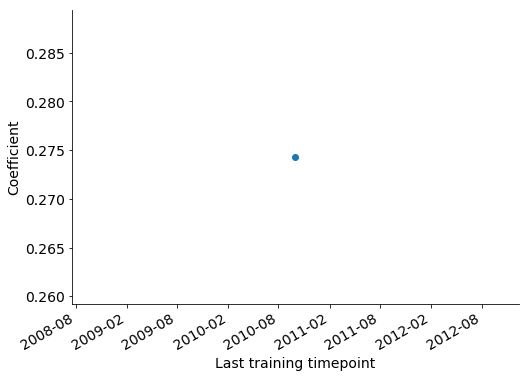

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(coefficients_df["last_training_timepoint"], coefficients_df["lbi"], "o")
ax.set_xlabel("Last training timepoint")
ax.set_ylabel("Coefficient")
plt.gcf().autofmt_xdate()

In [14]:
error.shape

(30, 6)

Text(0,0.5,'Estimated clade frequency')

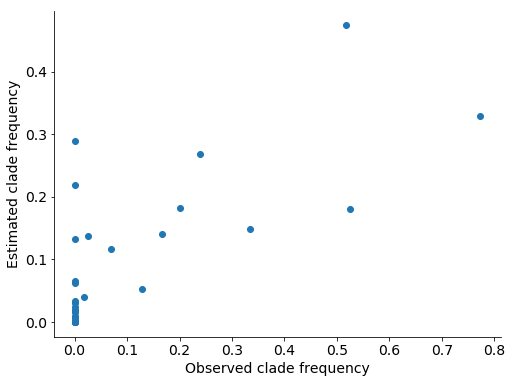

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(error["frequency"], error["frequency_hat"], "o")
ax.set_xlabel("Observed clade frequency")
ax.set_ylabel("Estimated clade frequency")

In [16]:
error.timepoint.unique()

array(['2009-10-01T00:00:00.000000000', '2010-04-01T00:00:00.000000000',
       '2010-10-01T00:00:00.000000000'], dtype='datetime64[ns]')

Text(0,0.5,'Number of clades')

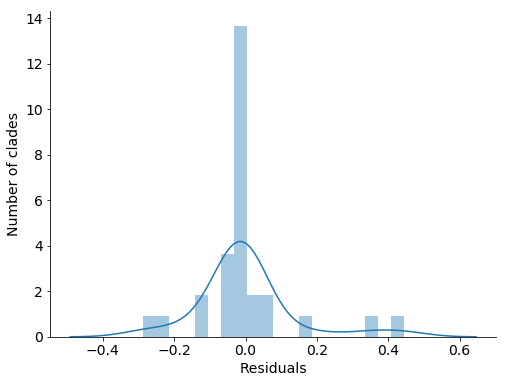

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.distplot(error["residual"], ax=ax, bins=20)
#ax.hist(error["residual"])
ax.set_xlabel("Residuals")
ax.set_ylabel("Number of clades")

In [18]:
residuals_by_timepoint = error.groupby("timepoint")["residual"].sum().reset_index()

In [19]:
residuals_by_timepoint

,timepoint,residual
0,2009-10-01,0.000002
1,2010-04-01,-0.000003
2,2010-10-01,-0.000005


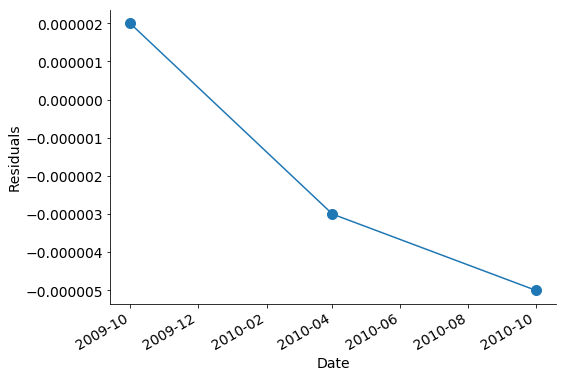

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(residuals_by_timepoint["timepoint"], residuals_by_timepoint["residual"], "o-", markersize=10)
ax.set_xlabel("Date")
ax.set_ylabel("Residuals")
plt.gcf().autofmt_xdate()

(-0.5, 2.5)

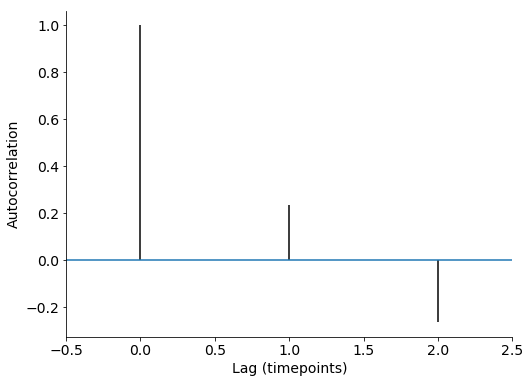

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

max_lags = len(residuals_by_timepoint["residual"]) - 1
lags, autocorrelation, lines, horizonal_lines = ax.acorr(
    residuals_by_timepoint["residual"],
    maxlags=max_lags
)
ax.set_xlabel("Lag (timepoints)")
ax.set_ylabel("Autocorrelation")
ax.set_xlim(-0.5, max_lags + 0.5)

Text(0,0.5,'Number of clades')

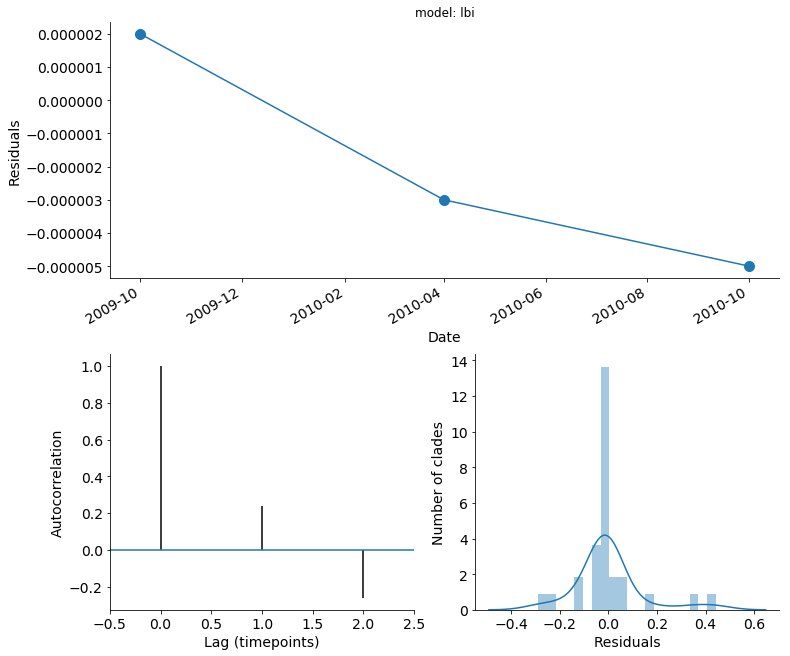

In [22]:
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(2, 2)
gs.update(hspace=0.3)

ax1 = plt.subplot(gs[0, :])
ax1.plot(residuals_by_timepoint["timepoint"], residuals_by_timepoint["residual"], "o-", markersize=10)
ax1.set_xlabel("Date")
ax1.set_ylabel("Residuals")
ax1.set_title("model: %s" % model_name)
plt.gcf().autofmt_xdate()

ax2 = plt.subplot(gs[1, :-1])
max_lags = len(residuals_by_timepoint["residual"]) - 1
lags, autocorrelation, lines, horizonal_lines = ax2.acorr(
    residuals_by_timepoint["residual"],
    maxlags=max_lags
)
ax2.set_xlabel("Lag (timepoints)")
ax2.set_ylabel("Autocorrelation")
ax2.set_xlim(-0.5, max_lags + 0.5)

ax3 = plt.subplot(gs[1:, -1])
sns.distplot(error["residual"], ax=ax3, bins=20)
ax3.set_xlabel("Residuals")
ax3.set_ylabel("Number of clades")

In [159]:
lags

array([-4, -3, -2, -1,  0,  1,  2,  3,  4])

In [160]:
autocorrelation

array([ 0.00127525,  0.00254064,  0.10723982, -0.00820112,  1.        ,
       -0.00820112,  0.10723982,  0.00254064,  0.00127525])

In [180]:
for clade, clade_df in error.groupby("clade_membership"):
    if clade_df["frequency"].max() > 0.5 and len(clade_df["timepoint"].unique()) > 3:
        print(clade)
        print(clade_df)
        break

HA1:50E,HA1:140I,HA1:158N,HA1:173Q,HA1:189K,HA1:193F,HA1:212A,HA1:225N,HA2:32R,HA2:46D,HA2:121K
                                     clade_membership  frequency  timepoint  \
1   HA1:50E,HA1:140I,HA1:158N,HA1:173Q,HA1:189K,HA...   0.538243 2009-10-01   
11  HA1:50E,HA1:140I,HA1:158N,HA1:173Q,HA1:189K,HA...   0.447790 2010-04-01   
24  HA1:50E,HA1:140I,HA1:158N,HA1:173Q,HA1:189K,HA...   0.168122 2010-10-01   
33  HA1:50E,HA1:140I,HA1:158N,HA1:173Q,HA1:189K,HA...   0.447790 2010-04-01   
46  HA1:50E,HA1:140I,HA1:158N,HA1:173Q,HA1:189K,HA...   0.168122 2010-10-01   
61  HA1:50E,HA1:140I,HA1:158N,HA1:173Q,HA1:189K,HA...   0.000000 2011-04-01   
73  HA1:50E,HA1:140I,HA1:158N,HA1:173Q,HA1:189K,HA...   0.168122 2010-10-01   
88  HA1:50E,HA1:140I,HA1:158N,HA1:173Q,HA1:189K,HA...   0.000000 2011-04-01   

    frequency_hat  residual last_training_timepoint  
1        0.383789  0.154454              2010-10-01  
11       0.320062  0.127728              2010-10-01  
24       0.003530  0.164592   

In [181]:
clade_df

,clade_membership,frequency,timepoint,frequency_hat,residual,last_training_timepoint
1,"HA1:50E,HA1:140I,HA1:158N,HA1:173Q,HA1:189K,HA...",0.538243,2009-10-01,0.383789,0.154454,2010-10-01
11,"HA1:50E,HA1:140I,HA1:158N,HA1:173Q,HA1:189K,HA...",0.447790,2010-04-01,0.320062,0.127728,2010-10-01
24,"HA1:50E,HA1:140I,HA1:158N,HA1:173Q,HA1:189K,HA...",0.168122,2010-10-01,0.003530,0.164592,2010-10-01
33,"HA1:50E,HA1:140I,HA1:158N,HA1:173Q,HA1:189K,HA...",0.447790,2010-04-01,0.320062,0.127728,2011-04-01
46,"HA1:50E,HA1:140I,HA1:158N,HA1:173Q,HA1:189K,HA...",0.168122,2010-10-01,0.003530,0.164592,2011-04-01
61,"HA1:50E,HA1:140I,HA1:158N,HA1:173Q,HA1:189K,HA...",0.000000,2011-04-01,0.008992,-0.008992,2011-04-01
73,"HA1:50E,HA1:140I,HA1:158N,HA1:173Q,HA1:189K,HA...",0.168122,2010-10-01,0.003530,0.164592,2011-10-01
88,"HA1:50E,HA1:140I,HA1:158N,HA1:173Q,HA1:189K,HA...",0.000000,2011-04-01,0.008992,-0.008992,2011-10-01


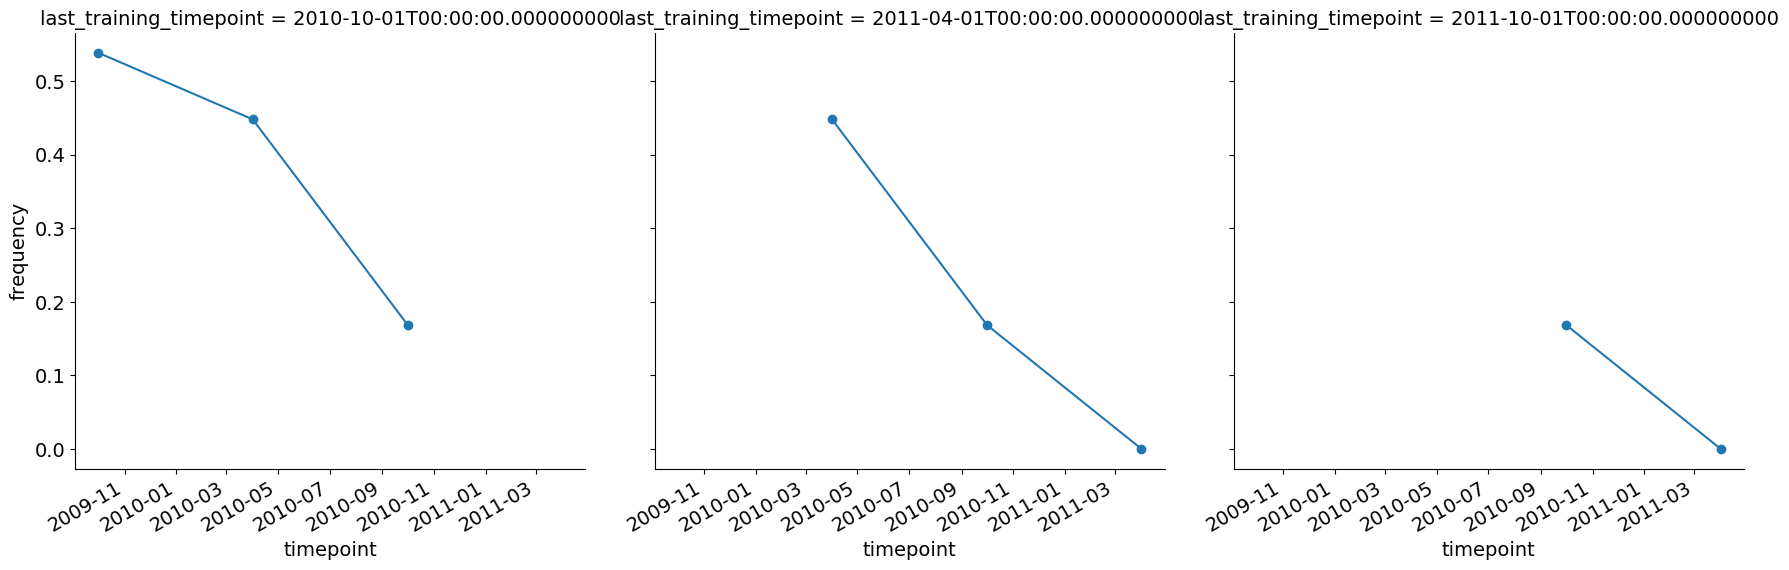

In [182]:
g = sns.FacetGrid(clade_df, col="last_training_timepoint", height=6)
g.map(plt.plot, "timepoint", "frequency", marker="o")
plt.gcf().autofmt_xdate()

In [184]:
clade_df.clade_membership.values

array(['HA1:50E,HA1:140I,HA1:158N,HA1:173Q,HA1:189K,HA1:193F,HA1:212A,HA1:225N,HA2:32R,HA2:46D,HA2:121K',
       'HA1:50E,HA1:140I,HA1:158N,HA1:173Q,HA1:189K,HA1:193F,HA1:212A,HA1:225N,HA2:32R,HA2:46D,HA2:121K',
       'HA1:50E,HA1:140I,HA1:158N,HA1:173Q,HA1:189K,HA1:193F,HA1:212A,HA1:225N,HA2:32R,HA2:46D,HA2:121K',
       'HA1:50E,HA1:140I,HA1:158N,HA1:173Q,HA1:189K,HA1:193F,HA1:212A,HA1:225N,HA2:32R,HA2:46D,HA2:121K',
       'HA1:50E,HA1:140I,HA1:158N,HA1:173Q,HA1:189K,HA1:193F,HA1:212A,HA1:225N,HA2:32R,HA2:46D,HA2:121K',
       'HA1:50E,HA1:140I,HA1:158N,HA1:173Q,HA1:189K,HA1:193F,HA1:212A,HA1:225N,HA2:32R,HA2:46D,HA2:121K',
       'HA1:50E,HA1:140I,HA1:158N,HA1:173Q,HA1:189K,HA1:193F,HA1:212A,HA1:225N,HA2:32R,HA2:46D,HA2:121K',
       'HA1:50E,HA1:140I,HA1:158N,HA1:173Q,HA1:189K,HA1:193F,HA1:212A,HA1:225N,HA2:32R,HA2:46D,HA2:121K'],
      dtype=object)